### Import Libraries

In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from sklearn.model_selection import train_test_split

import gdown
import zipfile

### Set working directory

In [2]:
#Change working directory to the base folder "ML_BarePass"

while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))


### Dowload dataset

#### Dowload from drive

In [3]:
dataset_name = "BrainCancer"

In [4]:
# Google Drive file ID
file_id = '1iLuOLiStCg8Nb8cxxaP4vrSj-lo5LqPx'

# Construct the download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Define the target directory
target_directory = 'data/raw'

# Ensure the target directory exists
os.makedirs(target_directory, exist_ok=True)

# Specify the output filename with the full path
output_filename = os.path.join(target_directory, f'{dataset_name}.zip')

# Check if the file already exists
if not os.path.exists(output_filename):
    # Download the file
    gdown.download(download_url, output=output_filename, quiet=False)
else:
    print(f"The file '{output_filename}' already exists. Skipping download.")

The file 'data/raw/BrainCancer.zip' already exists. Skipping download.


#### Unzip dataset zip file

In [5]:
output_filename

'data/raw/BrainCancer.zip'

In [6]:
def extract_and_rename(zip_file_path, target_directory, new_folder_name):
    # Ensure the target directory exists
    os.makedirs(target_directory, exist_ok=True)

    # Define the path for the extracted folder
    extracted_folder_path = os.path.join(target_directory, new_folder_name)

    # Check if the folder already exists
    if os.path.exists(extracted_folder_path):
        print(f"The folder '{new_folder_name}' already exists in {target_directory}. Skipping extraction.")
        return

    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the target directory
        zip_ref.extractall(target_directory)

    # Rename the extracted folder
    for item in os.listdir(target_directory):
        item_path = os.path.join(target_directory, item)
        if os.path.isdir(item_path):
            # Rename the first directory found
            os.rename(item_path, extracted_folder_path)
            print(f"Extracted folder renamed to '{new_folder_name}'")
            break
    else:
        print("No directory found in the ZIP file to rename.")

In [7]:
extract_and_rename(output_filename, target_directory, dataset_name)

The folder 'BrainCancer' already exists in data/raw. Skipping extraction.


### Create dataframe

In [8]:
raw_data_dir = os.path.join(target_directory,dataset_name)

# Collect file paths and labels using os.walk()
paths, labels = [], []

if os.path.isdir(raw_data_dir):
    for root, _, files in os.walk(raw_data_dir):
        label = os.path.basename(root)  # The last folder name is the label
        if root != raw_data_dir:  # Ensure we don't include the root folder itself
            paths.extend(os.path.join(root, file) for file in files)
            labels.extend([label] * len(files))



# Create DataFrame
df = pd.DataFrame({'filepath': paths, 'labels': labels})

In [9]:
df.sample(10)

,filepath,labels
10384,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma
6560,data/raw/BrainCancer/brain_tumor/brain_tumor_3...,brain_tumor
1334,data/raw/BrainCancer/brain_menin/brain_menin_4...,brain_menin
10520,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma
3219,data/raw/BrainCancer/brain_menin/brain_menin_1...,brain_menin
8031,data/raw/BrainCancer/brain_tumor/brain_tumor_0...,brain_tumor
2102,data/raw/BrainCancer/brain_menin/brain_menin_3...,brain_menin
11280,data/raw/BrainCancer/brain_glioma/brain_glioma...,brain_glioma
7874,data/raw/BrainCancer/brain_tumor/brain_tumor_0...,brain_tumor
9142,data/raw/BrainCancer/brain_tumor/brain_tumor_0...,brain_tumor


### Statistics

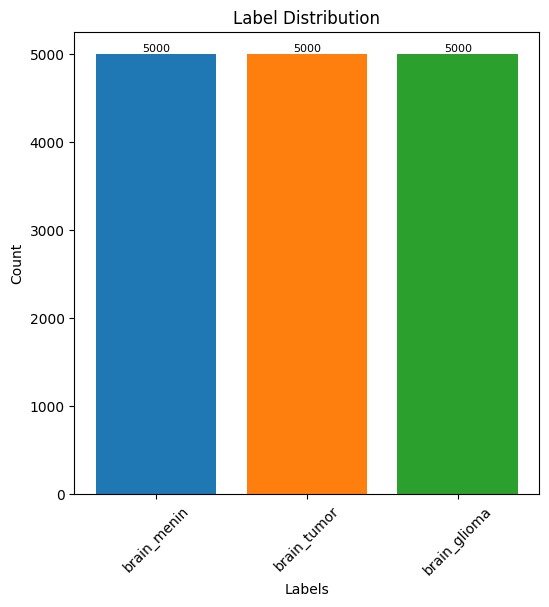

In [10]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']

# Generating unique colors for each bar
colors = plt.colormaps.get_cmap('tab10')

# Creating a vertical bar plot with different colors
plt.figure(figsize=(6, 6))
bars = plt.bar(count['labels'], count['count'], color=[colors(i) for i in range(len(count))])

# Adding numbers on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), 
             ha='center', va='bottom', fontsize=8)

# Labels and title
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(rotation=45)

# Show the plot
plt.show()


The dataset is balanced 

### Plot some images

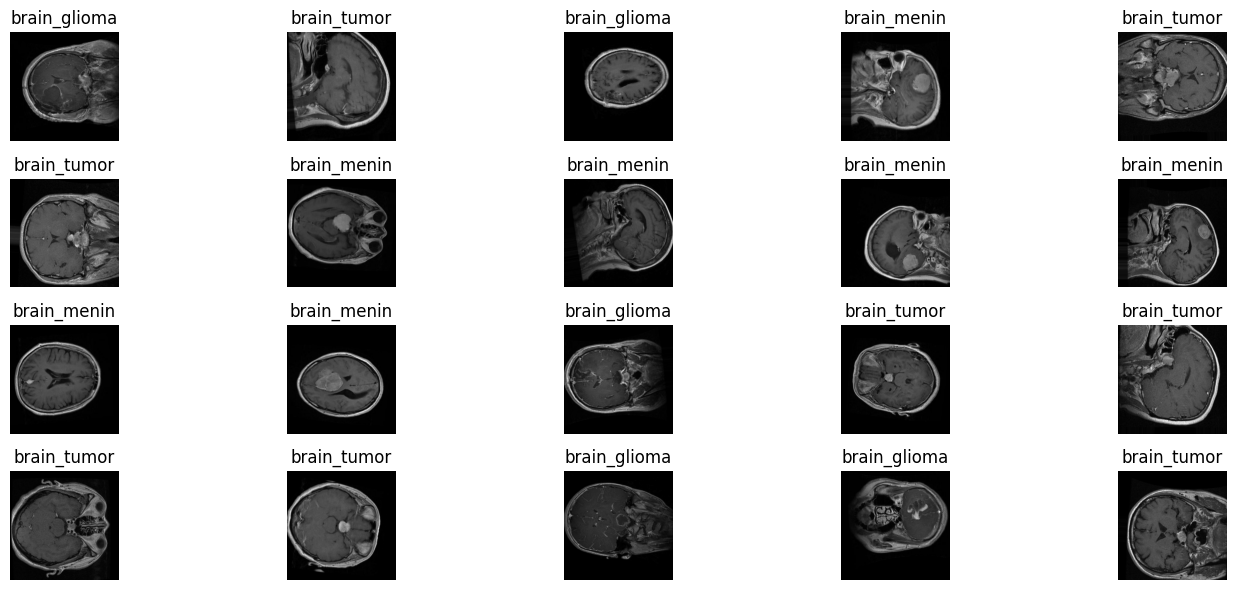

In [11]:
# Number of images to display
N = 20

# Sampling N images
samples = df.sample(N, random_state=42)

# Calculate the number of rows needed
ncols = 5
nrows = (N + ncols - 1) // ncols  # Equivalent to math.ceil(N / ncols)

# Creating a figure for displaying images
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))

# Flatten axes for easy iteration
axes = axes.flatten()

# Displaying images with labels
for i, (idx, row) in enumerate(samples.iterrows()):
    try:
        img = Image.open(row['filepath'])
        axes[i].imshow(img)
        axes[i].set_title(f"{row['labels']}")
        axes[i].axis('off')
    except Exception as e:
        axes[i].set_title("Error loading image")
        axes[i].axis('off')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Preprocessing: Cropping + Resizing

<Figure size 3000x800 with 0 Axes>

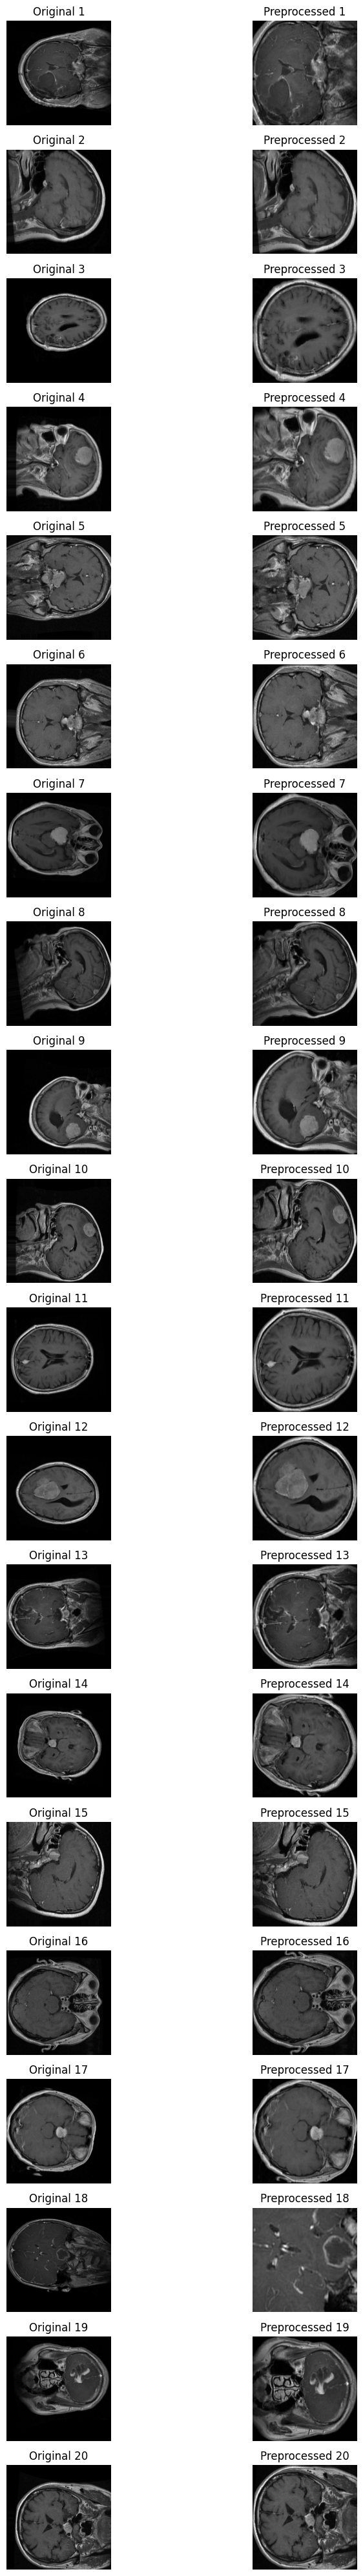

In [12]:
from skimage import io, transform, color
from keras.api.preprocessing.image import img_to_array
from src.data.preprocess import crop_brain_contour
plt.figure(figsize=(30, 8))

# Create a figure with subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 2 * N))

# Loop through each sample image
for i, image_path in enumerate(samples.filepath.values):
    # Load the original image
    original_image = io.imread(image_path)
    original_image = color.rgb2gray(original_image)
    original_image = (original_image * 255).astype(np.uint8)
    
    # Apply the crop_brain_contour function to get the cropped image
    cropped_image = crop_brain_contour(original_image)

    # Resize the cropped image
    image_resized = transform.resize(cropped_image, (224, 224), mode='reflect', anti_aliasing=True)
    image_array = img_to_array(image_resized)
    
    # Plot the original image in the left column
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title(f"Original {i+1}")
    axes[i, 0].axis('off')

    # Plot the preprocessed image in the right column
    axes[i, 1].imshow(image_array, cmap='gray')
    axes[i, 1].set_title(f"Preprocessed {i+1}")
    axes[i, 1].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Load dataset

In [10]:
from src.data.make_dataset import load_data

In [11]:
dataset = load_data(df)

2025-02-27 08:19:50.422596: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-27 08:19:50.422709: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-27 08:19:50.422713: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-27 08:19:50.422744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-27 08:19:50.422754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-27 08:23:09.889237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 124ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 124s 260ms/step


### Splitting dataset

In [12]:
X = dataset['fused_feature']
y = dataset['labels']

In [13]:
X.shape

(15000, 87808)

In [14]:
y.shape

(15000,)

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Print the value counts in y_train and y_test using numpy
print("\nClass distribution in y_train:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for class_label, count in zip(unique_train, counts_train):
    print(f"Class {class_label}: {count} samples")

print("\nClass distribution in y_test:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for class_label, count in zip(unique_test, counts_test):
    print(f"Class {class_label}: {count} samples")


Training set size: 12000 samples
Test set size: 3000 samples

Class distribution in y_train:
Class 0: 4000 samples
Class 1: 4000 samples
Class 2: 4000 samples

Class distribution in y_test:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples


In [16]:
save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

os.makedirs(train_folder,exist_ok=True)
# os.makedirs(val_folder,exist_ok=True)
os.makedirs(test_folder,exist_ok=True)


X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

# X_val_file = os.path.join(val_folder,'X_val.npy')
# y_val_file = os.path.join(val_folder,'y_val.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# Save training and test sets
np.save(X_train_file, X_train)
np.save(y_train_file, y_train)

# np.save(X_val_file, X_val)
# np.save(y_val_file, y_val)

np.save(X_test_file, X_test)
np.save(y_test_file, y_test)

In [1]:
import numpy as np
import os
#Change working directory to the base folder "ML_BarePass"

while os.path.basename(os.getcwd()) != "ML_BarePass":
    os.chdir((os.path.dirname(os.getcwd())))

save_dir = os.path.join(os.getcwd(),'data','processed')

train_folder = os.path.join(save_dir,'train')
# val_folder = os.path.join(save_dir,'val')
test_folder = os.path.join(save_dir,'test')

X_train_file = os.path.join(train_folder,'X_train.npy')
y_train_file = os.path.join(train_folder,'y_train.npy')

X_test_file = os.path.join(test_folder,'X_test.npy')
y_test_file = os.path.join(test_folder,'y_test.npy')

# To load the data later
X_train = np.load(X_train_file)
y_train = np.load(y_train_file)

X_test = np.load(X_test_file)
y_test = np.load(y_test_file)

### Models

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.decomposition import PCA

In [3]:
scalers = {
    "StandardScaler": StandardScaler()
}

classifiers = {
    "SVC": SVC(random_state=42, max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42)
}

reducers = {
    'PCA': PCA()
}

# Define parameters for each method
parameters = {
    "PCA__n_components": [0.1,0.2,0.5,0.8, None],
    "DecisionTreeClassifier__criterion": ['entropy','gini'],
    "StandardScaler__with_mean": [True, False],
    "StandardScaler__with_std": [True, False],
    "SVC__kernel": ['poly'],
    "SVC__degree": [3]
}


In [4]:
def generate_pipes_dict(pipe_dict):
    result = {}
    for config, steps in pipe_dict.items():
        
        #result[config] = generate_pipes(steps)
        result[config]= generate_pipes(steps)
    return result

def generate_pipes(pipe_config):
  
  pipe_config = [list(step.items()) for _, step in pipe_config]
  pipe_config = list(itertools.product(*pipe_config))
  pipe_names = list(map(lambda steps: [name for name,_ in steps], pipe_config))
  pipe_names = list(map(lambda L: ">".join(L), pipe_names))
  pipes = [Pipeline(cfg) for cfg in pipe_config]
  temp = zip(pipe_names, pipes)
  return dict(temp)

def find_hyperparams(pipe_mapper_dict):
  print("Start the tunning process ...")
  best_pipes = {}
  results = []
  counter = 0
  for name, pipe_mapper in pipe_mapper_dict.items():
   
    for idx, pipe_name in enumerate(list(pipe_mapper.keys())):
        
        print(f"{counter + 1}. Tuning pipe: {pipe_name}")

        # Select parameters related to the current pipeline:
        param_grid = {}
        for step_name in pipe_name.split('>'):
            for param_name in parameters.keys():
                if param_name.split("__")[0] == (step_name):
                    param_grid[param_name] = parameters[param_name]

        # Create a finder and search for the best parameters
        pipe = pipe_mapper[pipe_name]
        finder = GridSearchCV(pipe, param_grid=param_grid, cv=5,
                            scoring= "accuracy",
                            refit= True,n_jobs=None)

        finder.fit(X_train, y_train)
        print("\t best-params: {:>15s}".format(str(finder.best_params_)))
        print(f"\t best-score (PR_Auc): {finder.best_score_:15.2f}")
        #print(f"\t cv_result_: {finder.cv_results_}")
        print()

        # Store best pipe
        best_pipes[pipe_name] = finder.best_estimator_

        # Add results to a dataframe
        rs_item = {"Method": pipe_name, "Accuracy": finder.best_score_}
        for key, value in finder.best_params_.items():
            rs_item[key] = value
        results.append(rs_item)

        counter +=1

  print("The tunning is done!")
  tuned_table = pd.DataFrame(results)
  tuned_table.set_index('Method')   
  return tuned_table, best_pipes


In [5]:
pipe_dict = {
    # "NoReduce": [
    #     ('scalers', scalers),
    #     ('classifiers', classifiers)
    # ],
    
    "Reduced": [
        ('scalers', scalers),
        ('reducers', reducers),
        ('classifiers', classifiers)
    ]

}

pipe_mapper_dict = generate_pipes_dict(pipe_dict)

In [6]:
pipe_mapper_dict

{'Reduced': {'StandardScaler>PCA>SVC': Pipeline(steps=(('StandardScaler', StandardScaler()), ('PCA', PCA()),
                  ('SVC', SVC(max_iter=1000, random_state=42)))),
  'StandardScaler>PCA>DecisionTreeClassifier': Pipeline(steps=(('StandardScaler', StandardScaler()), ('PCA', PCA()),
                  ('DecisionTreeClassifier',
                   DecisionTreeClassifier(random_state=42))))}}

In [ ]:
tuned_table, best_pipes = find_hyperparams(pipe_mapper_dict)

Start the tunning process ...
1. Tuning pipe: StandardScaler>PCA>SVC


/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/mlproject/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/mlproject/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/mlproject/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/minhdang/Library/CloudStorage/OneDrive-Personal/242/ML/ML_BarePass/mlproject/lib/python3.12/site-packages/sklearn/svm/_base.py